<a href="https://colab.research.google.com/github/ryan-marcato/Classification-CIFAR10-with-vgg16/blob/main/vgg16_in_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
args = {
    "lr": 1e-3,
    "batch_size": 128,
    "num_epochs": 5
}

In [3]:
data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10('.',
                                 train=True,
                                 transform=data_transform,
                                 download=True)

test_dataset = datasets.CIFAR10('.',
                                train=False,
                                transform=data_transform,
                                download=True)

train_loader = DataLoader(train_dataset,
                          batch_size=args['batch_size'],
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=args["batch_size"],
                         shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


## Carregando modelo pré-treinado

In [4]:
model = models.vgg16(pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 164MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
# Congelando as camadas convolucionais
for param in model.parameters():
  param.requires_grad = False

## Modificando modelo pré-treinado

In [6]:
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 10)
)

model = model.to(device)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
for name, param in model.named_parameters():
    print(f"{name}: {'Treinável' if param.requires_grad else 'Congelado'}")

features.0.weight: Congelado
features.0.bias: Congelado
features.2.weight: Congelado
features.2.bias: Congelado
features.5.weight: Congelado
features.5.bias: Congelado
features.7.weight: Congelado
features.7.bias: Congelado
features.10.weight: Congelado
features.10.bias: Congelado
features.12.weight: Congelado
features.12.bias: Congelado
features.14.weight: Congelado
features.14.bias: Congelado
features.17.weight: Congelado
features.17.bias: Congelado
features.19.weight: Congelado
features.19.bias: Congelado
features.21.weight: Congelado
features.21.bias: Congelado
features.24.weight: Congelado
features.24.bias: Congelado
features.26.weight: Congelado
features.26.bias: Congelado
features.28.weight: Congelado
features.28.bias: Congelado
classifier.0.weight: Treinável
classifier.0.bias: Treinável
classifier.3.weight: Treinável
classifier.3.bias: Treinável


## função de perda e otimizador

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

## Treino da rede

In [9]:
for epoch in range(args["num_epochs"]):
    model.train()  # Modo de treinamento
    train_losses = []

    # Loop de treinamento
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)
        train_losses.append(loss.item())

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Atualização dos parâmetros
        optimizer.step()

    train_loss_avg = sum(train_losses) / len(train_losses)
    print(f"Época {epoch + 1}/{args['num_epochs']} - Custo médio no treino: {train_loss_avg:.4f}")

    # Avaliação no conjunto de teste
    model.eval()  # Modo de avaliação
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            # Forward
            scores = model(data)
            test_loss += criterion(scores, targets).item()

            # Acertos
            preds = scores.argmax(dim=1)
            correct += preds.eq(targets).sum().item()

    # Resultados do teste
    test_loss_avg = test_loss / len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss_avg:.4f}, Accuracy: {accuracy:.2f}%\n")


Época 1/5 - Custo médio no treino: 0.5468
Test Loss: 0.3854, Accuracy: 86.97%

Época 2/5 - Custo médio no treino: 0.3564
Test Loss: 0.3493, Accuracy: 87.98%

Época 3/5 - Custo médio no treino: 0.2975
Test Loss: 0.3833, Accuracy: 87.51%

Época 4/5 - Custo médio no treino: 0.2630
Test Loss: 0.3864, Accuracy: 87.89%

Época 5/5 - Custo médio no treino: 0.2190
Test Loss: 0.4052, Accuracy: 88.44%



## Plotando imagens com a previsão

In [21]:
classes = train_dataset.classes


def plot_predictions(model, loader, device, num_images=20):
    model.eval()  # Modo de avaliação
    images_shown = 0
    num_cols = num_images // 2
    fig, axes = plt.subplots(2, num_cols, figsize=(15, 6))

    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            # classes com maior probabilidade
            preds = outputs.argmax(dim=1)

            # Para cada imagem no batch
            for i in range(data.size(0)):
                if images_shown >= num_images:
                    break

                # Desnormaliza a imagem para exibir
                img = data[i].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

                # Determina a linha e a coluna na grid
                row = images_shown // num_cols
                col = images_shown % num_cols

                # Exibe a imagem com a label prevista
                axes[row, col].imshow(img)
                axes[row, col].set_title(f"Pred: {classes[preds[i].item()]}")
                axes[row, col].axis("off")
                images_shown += 1

            if images_shown >= num_images:
                break
    plt.tight_layout()
    plt.show()

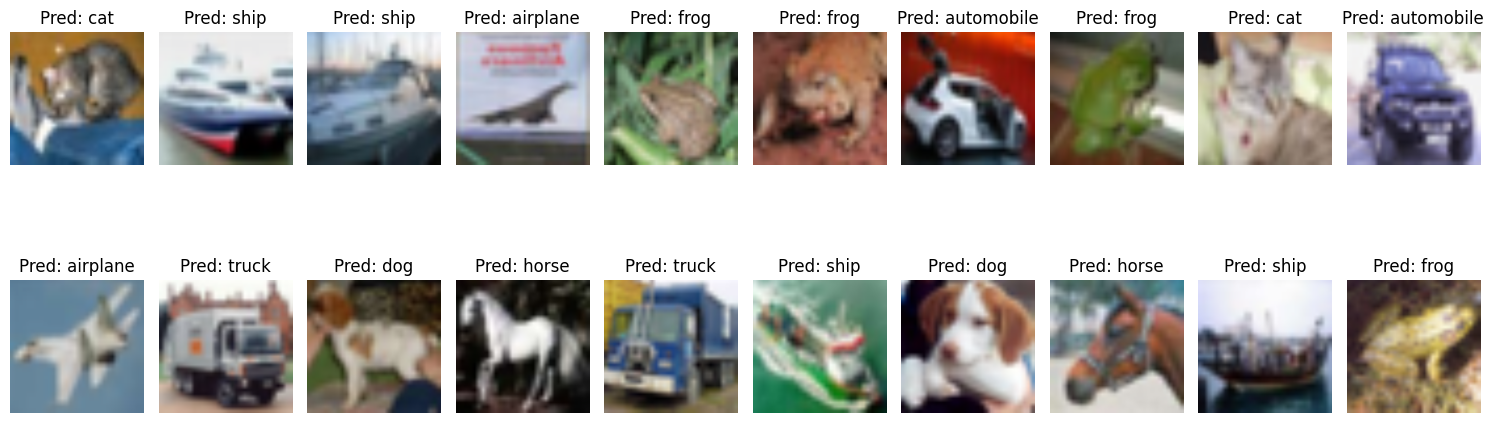

In [22]:
plot_predictions(model, test_loader, device)